In [26]:
import json
from typing import TypedDict, Annotated, Literal
from IPython.display import Image, display

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import ToolMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
class GraphState(TypedDict):
    question: str
    count: int

In [3]:
builder = StateGraph(GraphState)

In [4]:
def my_node(state: dict, config: RunnableConfig):
    print('In node: ', config['configurable']['user_id'])
    return {'results': f'Hello, {state['input']}!'}

def my_other_node(state: dict):
    return state

In [5]:
builder.add_node('my_node', my_node)
builder.add_node('my_other_node', my_other_node)

In [6]:
def route_start(state):
    if '안녕' in state['question']:
        return 'greeting'
    else:
        return 'search'

In [7]:
builder.add_conditional_edges(
    START,
    route_start,
    {'greeting':'my_node', 'search':'my_other_node'}
)

In [8]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [9]:
workflow = StateGraph(State)

In [10]:
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

def chatbot(state: State):
    return {'messages':[llm.invoke(state['messages'])]}

workflow.add_node('chatbot', chatbot)

In [11]:
workflow.set_entry_point('chatbot')
workflow.add_edge('chatbot', END)

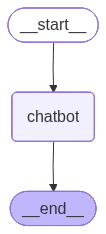

In [12]:
graph = workflow.compile()
graph

In [13]:
while True:
    user_input = input('User: ')

    if user_input.lower() in ['quit', 'exit', 'q']:
        print('다음에 뵈어요. :)')
        break

    for event in graph.stream({'messages':('user', user_input)}):
        for value in event.values():
            print('Assistant:', value['messages'][-1].content)

Assistant: Hello! How can I assist you today?
다음에 뵈어요. :)


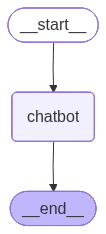

In [14]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
tool = TavilySearch(max_results=3)
tools = [tool]
tool.invoke('내일 대한민국 서울의 날씨는?')

{'query': '내일 대한민국 서울의 날씨는?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://korean.visitseoul.net/weather',
   'title': '서울 실시간 날씨 정보 | 서울 공식 관광정보 웹사이트',
   'content': '* 메뉴 바로가기 * 지금의 서울) 지금의 서울 + 전시/공연/축제/행사 + Visit Seoul 이벤트 + 서울 실시간 관광가이드 + 나의 서울 큐레이션 * 추천) 추천 + 에디터 추천 여행 + 서울 등산관광 + 서울관광 추천 테마코스 다양한 테마의 서울 여행 서울 여행에 대한   + About Seoul Family Site; "패밀리사이트 메뉴 열기")  * Visit Seoul API 서울의 날씨 **홈** >  여행정보 >  서울의 날씨 서울의 날씨 3일 예보 표 : 항목별(오늘, 내일, 모레) 날짜, 날씨, 최저/최고기온(℃), 강수확률 | 날씨 | 맑음 | 구름많고 한때 비 | 맑음 | 대기오염 상세 표 : 항목(오늘예보, 내일예보, 모레예보), 미세먼지(PM10), 초미세먼지(PM2.5) 주간예보 표 : 항목별 날짜, 날씨, 최저/최고기온(℃) | 날씨 | 맑음 | 구름많고 한때 비 | 맑음 | 흐림 | 흐리고 한때 비 |',
   'score': 0.77751994,
   'raw_content': None},
  {'url': 'https://www.accuweather.com/ko/kr/seoul/226081/weather-forecast/226081',
   'title': '서울특별시, 서울시, 대한민국 3일 날씨 예보 - AccuWeather',
   'content': '# 서울특별시, 서울시 46° 서울특별시, 서울시 날씨 오늘 WinterCast 지역 {stormName} 추적기 시간별 일별 레이더 MinuteCast® 월 대기질 건강 및 활동 ## 오

In [16]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

workflow = StateGraph(State)

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

workflow.add_node('chatbot', chatbot)

In [17]:
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
    
    def __call__(self, inputs: dict):
        if messages:= inputs.get('messages', []):
            message = messages[-1]
        else:
            raise ValueError('No Message found in input')
        
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call['name']].invoke(tool_call['args'])
            outputs.append(ToolMessage(
                content=json.dumps(tool_result, ensure_ascii=False),
                name=tool_call['name'],
                tool_call_id=tool_call['id']
            ))
        
        return {'messages':outputs}

In [18]:
tool_node = BasicToolNode(tools=[tool])

workflow.add_node('tools', tool_node)

In [19]:
def route_tools(state: State) -> Literal['tools', '__end__']:
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get('messages', []):
        ai_message = messages[-1]
    else:
        raise ValueError(f'No messages found in input state to tool_edge: {state}')
    
    if hasattr(ai_message, 'tool_calls') and len (ai_message.tool_calls) > 0:
        return 'tools'
    else:
        return '__end__'

In [20]:
workflow.add_conditional_edges(
    'chatbot',
    route_tools,
    {'tools':'tools', '__end__':'__end__'}
)

In [21]:
workflow.set_entry_point('chatbot')
workflow.add_edge('tools', 'chatbot')

In [22]:
graph = workflow.compile()

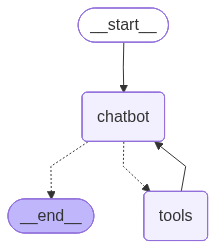

In [23]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
while True:
    user_input = input('User: ')
    print('User: ', user_input)
    if user_input.lower() in ['quit', 'exit', 'q']:
        print('다음에 뵈어요. :)')
        break

    events = graph.stream(input={'messages':[('user', user_input)]}, stream_mode='updates')

    for event in events:
        for value in event.values():
            if isinstance(value['messages'][-1], BaseMessage):
                print('Assistant: ', value['messages'][-1].content)
            else:
                raise ValueError('value error!')

User:  오늘 서울의 날씨는?
Assistant:  
Assistant:  {"query": "서울 날씨", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "http://www.snakorea.com/news/articleView.html?idxno=978546", "title": "[내일 날씨] 아침 영하권 추위…강풍에 체감온도 '뚝' - 서울뉴스통신", "content": "기온이 평년(최저 -4~6도, 최고 7~14도)과 비슷하거나 조금 낮겠다. 내일 아침 최저기온은 -5~5도, 낮 최고기온 6~12도가 되겠다. 지역별 아침 최저기온은 △ 서울 -", "score": 0.5441965, "raw_content": null}, {"url": "https://www.hankyung.com/article/202511278465i", "title": "기온 뚝…서울 아침 최저 영하 1도 [내일 날씨] - 한국경제", "content": "낮 최고기온은 6~12도로 예상된다. 기온은 평년보다 1~2도 낮은 수준이다. 수도권과 강원 내륙·산지, 충남은 아침 기온이 하루 만에 5~7도가량 떨어지고 바람이 약간", "score": 0.5100334, "raw_content": null}, {"url": "https://www.youtube.com/watch?v=yrZtTSWzlJc", "title": "[날씨] 밤까지 곳곳 비·눈‥내일 아침 영하권 추위 (2025.11.27/5시뉴스 ...", "content": "... 서울의 기온이 영하 1도, 장수 영하 2도, 대관령 영하 7도까지 떨어지겠고요. 찬 ... 날씨였습니다. https://imnews.imbc.com/replay/2025/nw1700/article", "score": 0.50886196, "raw_content": null}], "response_time": 0.53, "request_id": "0641f

In [27]:
memory = MemorySaver()

In [28]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [31]:
workflow = StateGraph(State)
tool = TavilySearch(max_results=3)
tools = [tool]
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools=[tool])

In [30]:
def chatbot(state: State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

In [32]:
workflow.add_node('chatbot', chatbot)
workflow.add_node('tools', tool_node)

workflow.set_entry_point('chatbot')
workflow.add_conditional_edges(
    'chatbot',
    tools_condition
)
workflow.add_edge('tools', 'chatbot')

graph = workflow.compile(checkpointer=memory)

In [34]:
config = {'configurable':{'thread_id':'1'}}